https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
import tensorflow as tf
#from tensorflow.python.client import device_lib

#tf.config.list_physical_devices('GPU')


In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [4]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [6]:
strFilename = '/Users/gauchetvanantwerpen/Documents/01 gvaLokaalDocs/01 Pers/02 Nisse/02 development/02 nissedb/results/BZ=F.csv'

df = pd.read_csv(strFilename,
                usecols=[1], engine='python')



In [7]:
dataset = df.values
dataset = df.astype('float32')

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

2476 1220


In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Default

In [12]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### Reshape
#### [samples, time steps, features]

In [13]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

2022-07-24 22:24:09.741657: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 22:24:09.742620: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
 - 6s - loss: 0.0168
Epoch 2/100
 - 5s - loss: 1.7473e-04
Epoch 3/100
 - 5s - loss: 1.7818e-04
Epoch 4/100
 - 5s - loss: 1.8420e-04
Epoch 5/100
 - 5s - loss: 1.8205e-04
Epoch 6/100
 - 5s - loss: 1.8495e-04
Epoch 7/100
 - 5s - loss: 1.7871e-04
Epoch 8/100
 - 5s - loss: 1.8383e-04
Epoch 9/100
 - 5s - loss: 1.8136e-04
Epoch 10/100
 - 5s - loss: 1.8155e-04
Epoch 11/100
 - 5s - loss: 1.8333e-04
Epoch 12/100
 - 5s - loss: 1.8437e-04
Epoch 13/100
 - 5s - loss: 1.8002e-04
Epoch 14/100
 - 5s - loss: 1.8607e-04
Epoch 15/100
 - 5s - loss: 1.8037e-04
Epoch 16/100
 - 5s - loss: 1.8459e-04
Epoch 17/100
 - 5s - loss: 1.8229e-04
Epoch 18/100
 - 5s - loss: 1.7907e-04
Epoch 19/100
 - 5s - loss: 1.8129e-04
Epoch 20/100
 - 5s - loss: 1.8019e-04
Epoch 21/100
 - 5s - loss: 1.7973e-04
Epoch 22/100
 - 5s - loss: 1.8210e-04
Epoch 23/100
 - 5s - loss: 1.8423e-04
Epoch 24/100
 - 5s - loss: 1.8030e-04
Epoch 25/100
 - 5s - loss: 1.8261e-04
Epoch 26/100
 - 5s - loss: 1.8159e-04
Epoch 27/100
 - 5s - loss

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.64 RMSE
Test Score: 1.83 RMSE


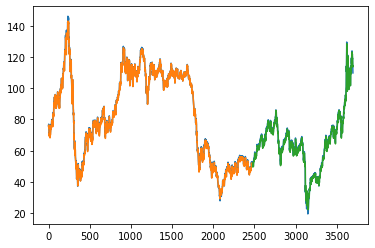

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## LSTM for Regression Using the Window Method

#### We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

#### This is called a window, and the size of the window is a parameter that can be tuned for each problem.

### Reshape
#### [samples, time steps, features]

In [17]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 6s - loss: 0.0258
Epoch 2/100
 - 5s - loss: 3.1481e-04
Epoch 3/100
 - 5s - loss: 3.1593e-04
Epoch 4/100
 - 5s - loss: 3.0985e-04
Epoch 5/100
 - 5s - loss: 3.0279e-04
Epoch 6/100
 - 5s - loss: 2.9241e-04
Epoch 7/100
 - 5s - loss: 2.7927e-04
Epoch 8/100
 - 5s - loss: 2.6888e-04
Epoch 9/100
 - 5s - loss: 2.5916e-04
Epoch 10/100
 - 5s - loss: 2.5195e-04
Epoch 11/100
 - 5s - loss: 2.3894e-04
Epoch 12/100
 - 5s - loss: 2.2825e-04
Epoch 13/100
 - 5s - loss: 2.3174e-04
Epoch 14/100
 - 5s - loss: 2.2147e-04
Epoch 15/100
 - 5s - loss: 2.1934e-04
Epoch 16/100
 - 5s - loss: 2.1064e-04
Epoch 17/100
 - 5s - loss: 2.1050e-04
Epoch 18/100
 - 5s - loss: 2.0248e-04
Epoch 19/100
 - 5s - loss: 2.0016e-04
Epoch 20/100
 - 5s - loss: 2.0020e-04
Epoch 21/100
 - 5s - loss: 2.0102e-04
Epoch 22/100
 - 5s - loss: 1.9767e-04
Epoch 23/100
 - 5s - loss: 1.9261e-04
Epoch 24/100
 - 5s - loss: 1.9653e-04
Epoch 25/100
 - 5s - loss: 1.9745e-04
Epoch 26/100
 - 5s - loss: 1.9389e-04
Epoch 27/100
 - 5s - loss

In [19]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.78 RMSE
Test Score: 1.88 RMSE


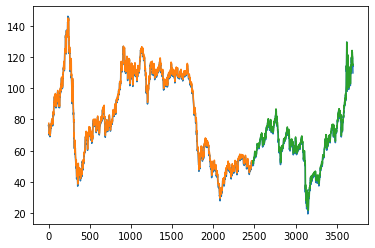

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM for Regression with Time Steps

#### Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

### Reshape

#### X=t and Y=t+1

In [21]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [22]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [23]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 10s - loss: 0.0235
Epoch 2/100
 - 9s - loss: 3.1061e-04
Epoch 3/100
 - 9s - loss: 2.9739e-04
Epoch 4/100
 - 9s - loss: 2.9925e-04
Epoch 5/100
 - 9s - loss: 2.7913e-04
Epoch 6/100
 - 9s - loss: 2.7315e-04
Epoch 7/100
 - 9s - loss: 2.6075e-04
Epoch 8/100
 - 9s - loss: 2.4232e-04
Epoch 9/100
 - 9s - loss: 2.1982e-04
Epoch 10/100
 - 9s - loss: 2.1444e-04
Epoch 11/100
 - 9s - loss: 2.1245e-04
Epoch 12/100
 - 9s - loss: 2.1006e-04
Epoch 13/100
 - 9s - loss: 2.0508e-04
Epoch 14/100
 - 9s - loss: 1.9863e-04
Epoch 15/100
 - 9s - loss: 1.9930e-04
Epoch 16/100
 - 9s - loss: 2.0041e-04
Epoch 17/100
 - 9s - loss: 1.9897e-04
Epoch 18/100
 - 9s - loss: 1.9723e-04
Epoch 19/100
 - 9s - loss: 1.9383e-04
Epoch 20/100
 - 9s - loss: 1.8616e-04
Epoch 21/100
 - 9s - loss: 1.8821e-04
Epoch 22/100
 - 9s - loss: 1.8389e-04
Epoch 23/100
 - 9s - loss: 1.8985e-04
Epoch 24/100
 - 9s - loss: 1.8491e-04
Epoch 25/100
 - 9s - loss: 1.8829e-04
Epoch 26/100
 - 9s - loss: 1.9581e-04
Epoch 27/100
 - 9s - los

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.61 RMSE
Test Score: 1.74 RMSE


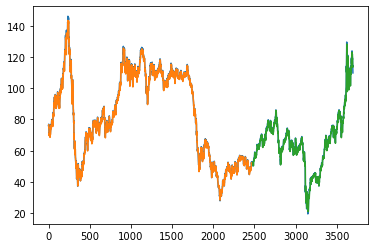

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### LSTM with Memory Between Batches

#### Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

#### We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

In [26]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [27]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 10s - loss: 0.0020
Epoch 1/1
 - 9s - loss: 5.1593e-04
Epoch 1/1
 - 9s - loss: 5.0955e-04
Epoch 1/1
 - 9s - loss: 5.0241e-04
Epoch 1/1
 - 9s - loss: 5.1543e-04
Epoch 1/1
 - 9s - loss: 5.2913e-04
Epoch 1/1
 - 9s - loss: 5.3517e-04
Epoch 1/1
 - 9s - loss: 5.3071e-04
Epoch 1/1
 - 9s - loss: 5.1191e-04
Epoch 1/1
 - 9s - loss: 5.0225e-04
Epoch 1/1
 - 9s - loss: 4.8180e-04
Epoch 1/1
 - 9s - loss: 4.6611e-04
Epoch 1/1
 - 9s - loss: 4.4856e-04
Epoch 1/1
 - 9s - loss: 4.3235e-04
Epoch 1/1
 - 9s - loss: 4.1669e-04
Epoch 1/1
 - 9s - loss: 4.0146e-04
Epoch 1/1
 - 9s - loss: 3.8618e-04
Epoch 1/1
 - 9s - loss: 3.7060e-04
Epoch 1/1
 - 9s - loss: 3.5484e-04
Epoch 1/1
 - 9s - loss: 3.3926e-04
Epoch 1/1
 - 9s - loss: 3.2437e-04
Epoch 1/1
 - 9s - loss: 3.1065e-04
Epoch 1/1
 - 9s - loss: 2.9823e-04
Epoch 1/1
 - 9s - loss: 2.8726e-04
Epoch 1/1
 - 9s - loss: 2.7735e-04
Epoch 1/1
 - 9s - loss: 2.6672e-04
Epoch 1/1
 - 9s - loss: 2.4925e-04
Epoch 1/1
 - 9s - loss: 2.2469e-04
Epoch 1/1
 - 9s - loss:

In [28]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.45 RMSE
Test Score: 6.02 RMSE


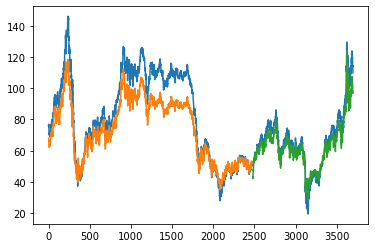

In [29]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Stacked LSTMs with Memory Between Batches

#### Finally, we will take a look at one of the big benefits of LSTMs: 
### The fact that they can be successfully trained when stacked into deep network architectures.

#### LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to True.

In [30]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [31]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

Epoch 1/1
 - 18s - loss: 0.0052
Epoch 1/1
 - 17s - loss: 0.0012
Epoch 1/1
 - 17s - loss: 0.0014
Epoch 1/1
 - 17s - loss: 0.0014
Epoch 1/1
 - 17s - loss: 0.0018
Epoch 1/1
 - 17s - loss: 0.0019
Epoch 1/1
 - 17s - loss: 0.0020
Epoch 1/1
 - 17s - loss: 0.0021
Epoch 1/1
 - 17s - loss: 0.0022
Epoch 1/1
 - 17s - loss: 0.0021
Epoch 1/1
 - 17s - loss: 0.0020
Epoch 1/1
 - 17s - loss: 0.0017
Epoch 1/1
 - 17s - loss: 0.0014
Epoch 1/1
 - 17s - loss: 0.0012
Epoch 1/1
 - 19s - loss: 0.0010
Epoch 1/1
 - 17s - loss: 8.8965e-04
Epoch 1/1
 - 17s - loss: 7.9469e-04
Epoch 1/1
 - 17s - loss: 7.1847e-04
Epoch 1/1
 - 17s - loss: 6.5473e-04
Epoch 1/1
 - 17s - loss: 6.0066e-04
Epoch 1/1
 - 17s - loss: 5.5452e-04
Epoch 1/1
 - 17s - loss: 5.1523e-04
Epoch 1/1
 - 17s - loss: 4.8181e-04
Epoch 1/1
 - 17s - loss: 4.5326e-04
Epoch 1/1
 - 17s - loss: 4.2866e-04
Epoch 1/1
 - 17s - loss: 4.0714e-04
Epoch 1/1
 - 17s - loss: 3.8642e-04
Epoch 1/1
 - 17s - loss: 3.7583e-04
Epoch 1/1
 - 17s - loss: 3.6512e-04
Epoch 1/1
 - 17s

In [32]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.29 RMSE
Test Score: 4.93 RMSE


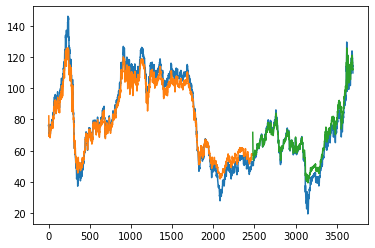

In [33]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()